extract_and_flatten_folders

In [16]:
import os
import shutil

def extract_and_flatten_folders(base_dir):
    """
    Extract contents from second-level subfolders and move them to the parent subfolder.
    Deletes the second-level subfolder after moving contents.
    """
    for root, dirs, files in os.walk(base_dir):
        for dir_name in dirs:
            second_level_path = os.path.join(root, dir_name, dir_name)
            if os.path.exists(second_level_path):
                # Move all contents from the second-level folder to the first-level folder
                for item in os.listdir(second_level_path):
                    source_path = os.path.join(second_level_path, item)
                    destination_path = os.path.join(root, dir_name, item)
                    shutil.move(source_path, destination_path)

                # Remove the now-empty second-level subfolder
                os.rmdir(second_level_path)

# Define the directories to process
directories = [
    r"D:\Unet\First_100_Sep_DRR_PA"
]

# Apply the function to each directory
for directory in directories:
    extract_and_flatten_folders(directory)

print("Processing complete!")


Processing complete!


process_chest_image

In [3]:
import os
import numpy as np
from PIL import Image
import nibabel as nib

def load_image(image_path):
    """Load the image in grayscale mode and return as a NumPy array."""
    img = Image.open(image_path).convert('L')
    return np.array(img)

def normalize_clip(image, min_val=0, max_val=255):
    """Clip the image values to the range [min_val, max_val]."""
    return np.clip(image, min_val, max_val)

def normalize_rescale(image, min_val=0, max_val=255):
    """Rescale the image values to the range [min_val, max_val]."""
    img_min, img_max = image.min(), image.max()
    return ((image - img_min) / (img_max - img_min)) * (max_val - min_val) + min_val

def save_nifti(image, output_path):
    """Save the image as a NIfTI file."""
    rotation_90_left = np.array([
    [0,  1, 0, 0],
    [-1, 0, 0, 0],
    [0,  0, 1, 0],
    [0,  0, 0, 1]
])
    nifti_img = nib.Nifti1Image(image, affine=rotation_90_left)
    nib.save(nifti_img, output_path)

def process_subtraction(image, original_name, output_dir):
    """Process subtraction operations and save results."""
    for value in range(30, 80, 5):
        subtracted_image = image - value
        
        # Normalize using both methods
        clipped_image = normalize_clip(subtracted_image)
        rescaled_image = normalize_rescale(subtracted_image)
        
        # Save files
        save_nifti(clipped_image, os.path.join(output_dir, f"{original_name}_M{value}_C_0000.nii.gz"))
        save_nifti(rescaled_image, os.path.join(output_dir, f"{original_name}_M{value}_R_0000.nii.gz"))

def process_multiplication(image, original_name, output_dir):
    """Process multiplication operations and save results."""
    for factor in np.arange(0.95, 0.79, -0.03):
        multiplied_image = image * factor
        
        # Normalize using both methods
        clipped_image = normalize_clip(multiplied_image)
        rescaled_image = normalize_rescale(multiplied_image)
        
        # Save files
        save_nifti(clipped_image, os.path.join(output_dir, f"{original_name}_D{int(factor*100):02d}_C_0000.nii.gz"))
        save_nifti(rescaled_image, os.path.join(output_dir, f"{original_name}_D{int(factor*100):02d}_R_0000.nii.gz"))

def main():
    image_path = r"d:\Unet\Practice_PNGandJPG\chestimage_JPG\JPCLN001.jpg"
    output_dir = r"d:\Unet\Processed_NIfTI"
    original_name = os.path.splitext(os.path.basename(image_path))[0]
    
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # Load the image
    image = load_image(image_path)
    
    # Process the image
    process_subtraction(image, original_name, output_dir)
    #process_multiplication(image, original_name, output_dir)

if __name__ == "__main__":
    main()


In [117]:
def combine_images(images, method='max'):
    """
    Combine multiple images using a specified method.
    Default method is 'max' to get the highest intensity at each pixel.
    """
    combined_image = None
    
    if method == "04":
        # Extract images by index
        spine_image = images[0]  # First image
        bones_image = images[1]  # Second image
        rib_image = images[2]    # Third image
        soft_tissue_image = images[3]  # Fourth image
        bones = spine_image*0.7 + bones_image*0.9 + rib_image 
        combined_image = (bones*0.4 + soft_tissue_image) / 2
        
    if method == "st":
        # Extract images by index
        spine_image = images[0]  # First image
        bones_image = images[1]  # Second image
        rib_image = images[2]    # Third image
        soft_tissue_image = images[3]  # Fourth image
        bones = spine_image*0.7 + bones_image*0.3 + rib_image 
        combined_image = (bones*0.4 + soft_tissue_image) / 2
        

    for img in images:
        if img is None:
            continue  # Skip if an image failed to load
        if combined_image is None:
            combined_image = img
        else:
            if method == 'max':
                combined_image = np.maximum(combined_image, img)
            elif method == 'average':
                combined_image = (combined_image + img) / 2
            elif method == 'min':
                combined_image = np.minimum(combined_image, img)
            

    return combined_image

def process_and_combine_images(input_folder, output_folder, patient_id, method='max'):
    """
    Process the images (spine, rib, bone, soft tissue), combine them, and save the result.
    """
     # Paths to the images
    image_paths = {
        "spine": os.path.join(input_folder, f"{patient_id}_spine_real.jpg"),
        "bones": os.path.join(input_folder, f"{patient_id}_bones_real.jpg"),
        "rib": os.path.join(input_folder, f"{patient_id}_rib_real.jpg"),
        "soft_tissue": os.path.join(input_folder, f"{patient_id}_soft_tissue.jpg")
    }

    # Load images
    images = [load_image(path) for path in image_paths.values()]

    # Combine images
    combined_image = combine_images(images, method)
    return combined_image

In [95]:
folder  = r"D:\Unet\First_100_Sep_DRR\t_87_a_1"
output = ""
patient_id = os.path.basename(folder)
process_and_combine_images(folder, output, patient_id, method='max')

array([[239, 237, 233, ..., 213, 211, 210],
       [244, 243, 239, ..., 216, 214, 213],
       [245, 247, 245, ..., 221, 219, 218],
       ...,
       [113, 114, 116, ..., 108, 106, 105],
       [112, 113, 115, ..., 107, 105, 104],
       [112, 113, 115, ..., 107, 105, 104]], dtype=uint8)

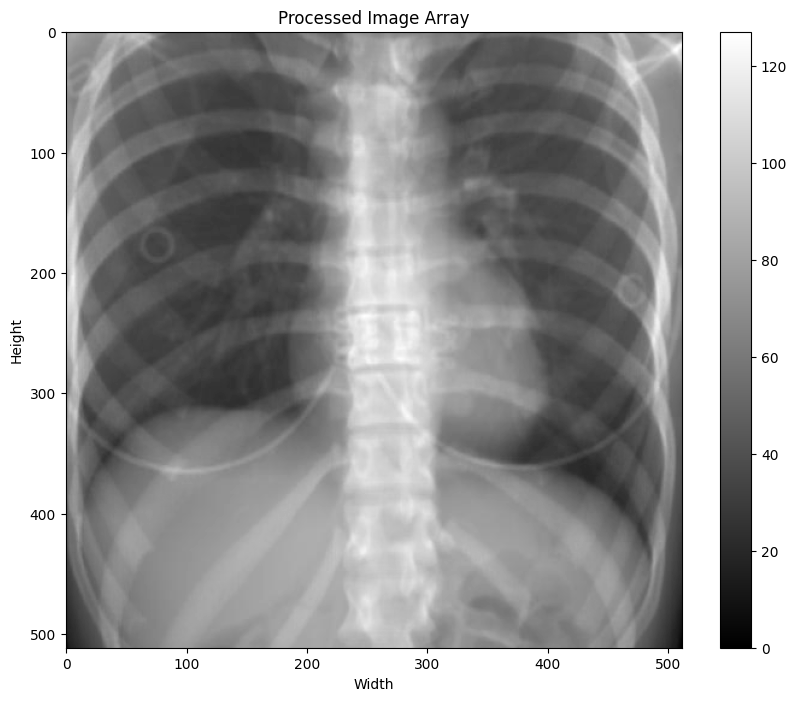

In [118]:
import matplotlib.pyplot as plt
folder  = r"D:\Unet\First_100_Sep_DRR_PA\t_2890_a_1"
patient_id = os.path.basename(folder)
 
# Assuming `process_and_combine_images` returns a 2D array
array = process_and_combine_images(folder, output, patient_id, method='st')

# Plot the array as a heatmap
plt.figure(figsize=(10, 8))
plt.imshow(array, cmap='gray')  # Use grayscale colormap for visualization
plt.colorbar()  # Add a color bar to show intensity values
plt.title("Processed Image Array")
plt.xlabel("Width")
plt.ylabel("Height")
plt.show()


In [112]:
import os
import numpy as np
from PIL import Image  # For saving numpy arrays as images



# Define the input and output directories
input_root = r"D:\Unet\First_100_Sep_DRR_PA"
output_root = r"D:\Unet\First_100_Sep_DRR_PA_avg"

# Create the output directory if it doesn't exist
if not os.path.exists(output_root):
    os.makedirs(output_root)

# Iterate through all folders in the input directory
for folder_name in os.listdir(input_root):
    folder_path = os.path.join(input_root, folder_name)
    
    # Check if it's a directory
    if os.path.isdir(folder_path):
        # Process the folder
        output = ""  # Assuming this is not used in your function
        patient_id = os.path.basename(folder_path)
        array = process_and_combine_images(folder_path, output, patient_id, method='04')
        array_normalized = (array - np.min(array)) / (np.max(array) - np.min(array))
        array_scaled = (array_normalized * 255).astype(np.uint8)


        # Save the numpy array as a grayscale JPEG image
        output_path = os.path.join(output_root, f"{patient_id}.jpg")
        result_image = Image.fromarray(array_scaled.astype(np.uint8), mode='L')  # 'L' mode for grayscale
        result_image.save(output_path)
        
        #print(f"Processed and saved: {output_path}")

Processed and saved: D:\imgstd\avg_drr_04\t_10168_a_1.jpg
Processed and saved: D:\imgstd\avg_drr_04\t_10292_a_1.jpg
Processed and saved: D:\imgstd\avg_drr_04\t_10325_a_1.jpg
Processed and saved: D:\imgstd\avg_drr_04\t_10894_a_1.jpg
Processed and saved: D:\imgstd\avg_drr_04\t_11021_a_1.jpg
Processed and saved: D:\imgstd\avg_drr_04\t_11170_a_1.jpg
Processed and saved: D:\imgstd\avg_drr_04\t_11322_a_1.jpg
Processed and saved: D:\imgstd\avg_drr_04\t_11626_a_1.jpg
Processed and saved: D:\imgstd\avg_drr_04\t_11810_a_1.jpg
Processed and saved: D:\imgstd\avg_drr_04\t_11917_a_1.jpg
Processed and saved: D:\imgstd\avg_drr_04\t_12122_a_1.jpg
Processed and saved: D:\imgstd\avg_drr_04\t_12209_b_1.jpg
Processed and saved: D:\imgstd\avg_drr_04\t_12389_a_1.jpg
Processed and saved: D:\imgstd\avg_drr_04\t_12507_a_1.jpg
Processed and saved: D:\imgstd\avg_drr_04\t_12566_a_1.jpg
Processed and saved: D:\imgstd\avg_drr_04\t_12703_b_1.jpg
Processed and saved: D:\imgstd\avg_drr_04\t_13068_a_1.jpg
Processed and 

Histogram matching

In [ ]:
import os
import numpy as np
from PIL import Image
from skimage.exposure import match_histograms
import matplotlib.pyplot as plt

# Define the input and output directories
avg_drr_folder = r"D:\imgstd\avg_drr_04_piecewise_map_blur"  # Source folder (to be adapted)
healthy_sample_folder = r"D:\imgstd\healthy_sample"  # Target folder (reference)
output_folder = r"D:\imgstd\avg_drr_adapted"  # Output folder for adapted images

# Create the output directory if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Function to compute the histogram of an image
def compute_histogram(image):
    return np.histogram(image, bins=256, range=(0, 255))[0]

# Function to normalize and scale an image to [0, 255]
def normalize_to_uint8(image):
    image_normalized = (image - np.min(image)) / (np.max(image) - np.min(image))
    return (image_normalized * 255).astype(np.uint8)

# Function to create a reference image from a histogram
def create_reference_image_from_histogram(histogram, image_shape):
    # Create a cumulative distribution function (CDF) from the histogram
    cdf = np.cumsum(histogram)
    cdf_normalized = cdf / cdf[-1]  # Normalize to [0, 1]

    # Create a lookup table to map pixel values
    lookup_table = np.interp(np.linspace(0, 1, 256), cdf_normalized, np.arange(256)).astype(np.uint8)

    # Generate a reference image using the lookup table
    reference_image = np.random.rand(*image_shape) * 255  # Random image with the same shape
    reference_image = lookup_table[reference_image.astype(np.uint8)]
    return reference_image

# Step 1: Compute the average histogram of the images in healthy_sample_folder (target)
histograms = []
for filename in os.listdir(healthy_sample_folder):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        image_path = os.path.join(healthy_sample_folder, filename)
        image = np.array(Image.open(image_path).convert('L'))  # Convert to grayscale
        histograms.append(compute_histogram(image))

# Calculate the average histogram
average_histogram = np.mean(histograms, axis=0)

# Step 2: Apply histogram matching to each image in avg_drr_folder (source)
for filename in os.listdir(avg_drr_folder):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        image_path = os.path.join(avg_drr_folder, filename)
        image = np.array(Image.open(image_path).convert('L'))  # Convert to grayscale

        # Create a reference image from the average histogram
        reference_image = create_reference_image_from_histogram(average_histogram, image.shape)

        # Perform histogram matching
        matched_image = match_histograms(image, reference_image)

        # Normalize and scale the matched image to [0, 255]
        matched_image = normalize_to_uint8(matched_image)

        # Save the transformed image
        output_path = os.path.join(output_folder, filename)
        Image.fromarray(matched_image).save(output_path)

        #print(f"Processed and saved: {output_path}")

piecewise_linear_mapping adjust contrast

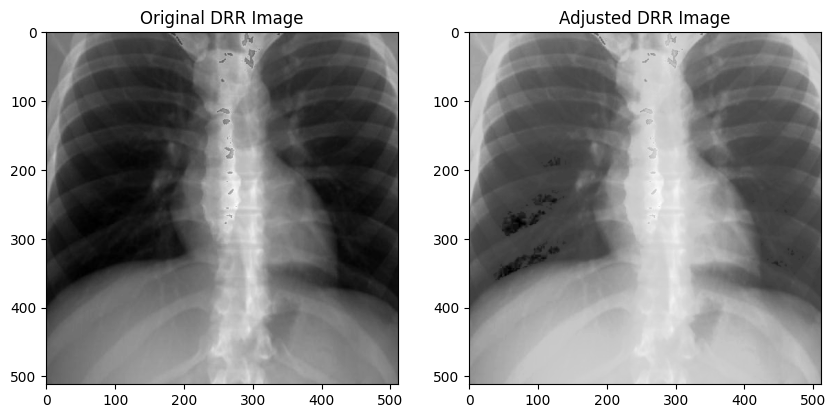

In [107]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Define the piecewise linear mapping function
def piecewise_linear_mapping(image):
    # Define the key points for the mapping
    drr_low = 8
    drr_high = 40
    cxr_low = 60
    cxr_high = 80

    drr_bright_low = 140
    drr_bright_high = 190
    cxr_bright_low = 198
    cxr_bright_high = 215

    # Create a lookup table for the mapping
    lookup_table = np.zeros(256, dtype=np.uint8)

    # Map the lung region (8, 40) -> (60, 80)
    for i in range(drr_low, drr_high + 1):
        lookup_table[i] = np.interp(i, [drr_low, drr_high], [cxr_low, cxr_high])

    # Map the bright region (160, 185) -> (210, 235)
    for i in range(drr_bright_low, drr_bright_high + 1):
        lookup_table[i] = np.interp(i, [drr_bright_low, drr_bright_high], [cxr_bright_low, cxr_bright_high])

    # Linear mapping for the remaining ranges
    lookup_table[:drr_low] = np.interp(np.arange(drr_low), [0, drr_low], [0, cxr_low])
    lookup_table[drr_high:drr_bright_low] = np.interp(np.arange(drr_high, drr_bright_low), [drr_high, drr_bright_low], [cxr_high, cxr_bright_low])
    lookup_table[drr_bright_high:] = np.interp(np.arange(drr_bright_high, 256), [drr_bright_high, 255], [cxr_bright_high, 255])

    # Apply the lookup table to the image
    return lookup_table[image]

# Load the DRR image
image_path = r"d:\imgstd\avg_drr_04\t_87_a_1.jpg"
image = np.array(Image.open(image_path).convert('L'))  # Convert to grayscale

# Apply the piecewise linear mapping
adjusted_image = piecewise_linear_mapping(image)

# Save the adjusted image
output_path = r"D:\imgstd\1\t_10168_a_1.jpg"
Image.fromarray(adjusted_image).save(output_path)

# Plot the original and adjusted images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title("Original DRR Image")
plt.subplot(1, 2, 2)
plt.imshow(adjusted_image, cmap='gray')
plt.title("Adjusted DRR Image")
plt.show()

In [113]:
# Define the input and output directories
input_folder = r"D:\imgstd\avg_drr_04"
output_folder = r"D:\imgstd\avg_drr_04_piecewise_map"

# Create the output directory if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Iterate through all images in the input folder
for filename in os.listdir(input_folder):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        # Load the image
        image_path = os.path.join(input_folder, filename)
        image = np.array(Image.open(image_path).convert('L'))  # Convert to grayscale

        # Apply the piecewise linear mapping
        adjusted_image = piecewise_linear_mapping(image)

        # Save the adjusted image
        output_path = os.path.join(output_folder, filename)
        Image.fromarray(adjusted_image).save(output_path)

        print(f"Processed and saved: {output_path}")

Processed and saved: D:\imgstd\avg_drr_04_piecewise_map\t_10168_a_1.jpg
Processed and saved: D:\imgstd\avg_drr_04_piecewise_map\t_10292_a_1.jpg
Processed and saved: D:\imgstd\avg_drr_04_piecewise_map\t_10325_a_1.jpg
Processed and saved: D:\imgstd\avg_drr_04_piecewise_map\t_10894_a_1.jpg
Processed and saved: D:\imgstd\avg_drr_04_piecewise_map\t_11021_a_1.jpg
Processed and saved: D:\imgstd\avg_drr_04_piecewise_map\t_11170_a_1.jpg
Processed and saved: D:\imgstd\avg_drr_04_piecewise_map\t_11322_a_1.jpg
Processed and saved: D:\imgstd\avg_drr_04_piecewise_map\t_11626_a_1.jpg
Processed and saved: D:\imgstd\avg_drr_04_piecewise_map\t_11810_a_1.jpg
Processed and saved: D:\imgstd\avg_drr_04_piecewise_map\t_11917_a_1.jpg
Processed and saved: D:\imgstd\avg_drr_04_piecewise_map\t_12122_a_1.jpg
Processed and saved: D:\imgstd\avg_drr_04_piecewise_map\t_12209_b_1.jpg
Processed and saved: D:\imgstd\avg_drr_04_piecewise_map\t_12389_a_1.jpg
Processed and saved: D:\imgstd\avg_drr_04_piecewise_map\t_12507_

In [52]:
import numpy as np
from PIL import Image
from scipy.ndimage import gaussian_filter

Apply noise

In [54]:
def apply_noise_and_blur(image_path, lower_bound, upper_bound, lower_noise_param, upper_noise_param, lower_blur_param, upper_blur_param):
    """
    Applies noise and blur to an image based on pixel intensity ranges.

    Parameters:
        image_path (str): Path to the input image.
        lower_bound (int): Lower intensity bound for transition (e.g., 80).
        upper_bound (int): Upper intensity bound for transition (e.g., 100).
        lower_noise_param (float): Noise parameter for intensities below lower_bound.
        upper_noise_param (float): Noise parameter for intensities above upper_bound.
        lower_blur_param (float): Blur parameter for intensities below lower_bound.
        upper_blur_param (float): Blur parameter for intensities above upper_bound.

    Returns:
        np.ndarray: Processed image as a NumPy array.
    """
    # Load the image and convert to grayscale
    image = np.array(Image.open(image_path).convert('L'), dtype=np.float32)

    # Create masks for different intensity ranges
    mask_low = image < lower_bound
    mask_mid = (image >= lower_bound) & (image < upper_bound)
    mask_high = image >= upper_bound

    # Initialize output image
    processed_image = np.zeros_like(image)

    # Apply noise to the entire image
    noise = np.random.normal(0, 1, image.shape)  # Base noise
    noise_low = lower_noise_param * noise
    noise_high = upper_noise_param * noise

    # Interpolate noise for the mid-intensity region
    transition_mask = np.clip((image - lower_bound) / (upper_bound - lower_bound), 0, 1)
    noise_mid = noise_low + transition_mask * (noise_high - noise_low)

    # Combine noise for all regions
    noisy_image = image + np.where(mask_low, noise_low, np.where(mask_high, noise_high, noise_mid))

    # Apply blur to the entire image
    blur_low = gaussian_filter(noisy_image, sigma=lower_blur_param)
    blur_high = gaussian_filter(noisy_image, sigma=upper_blur_param)

    # Interpolate blur for the mid-intensity region
    blur_mid = blur_low + transition_mask * (blur_high - blur_low)

    # Combine blur for all regions
    processed_image = np.where(mask_low, blur_low, np.where(mask_high, blur_high, blur_mid))

    # Clip to valid range and convert to uint8
    processed_image = np.clip(processed_image, 0, 255).astype(np.uint8)

    return processed_image

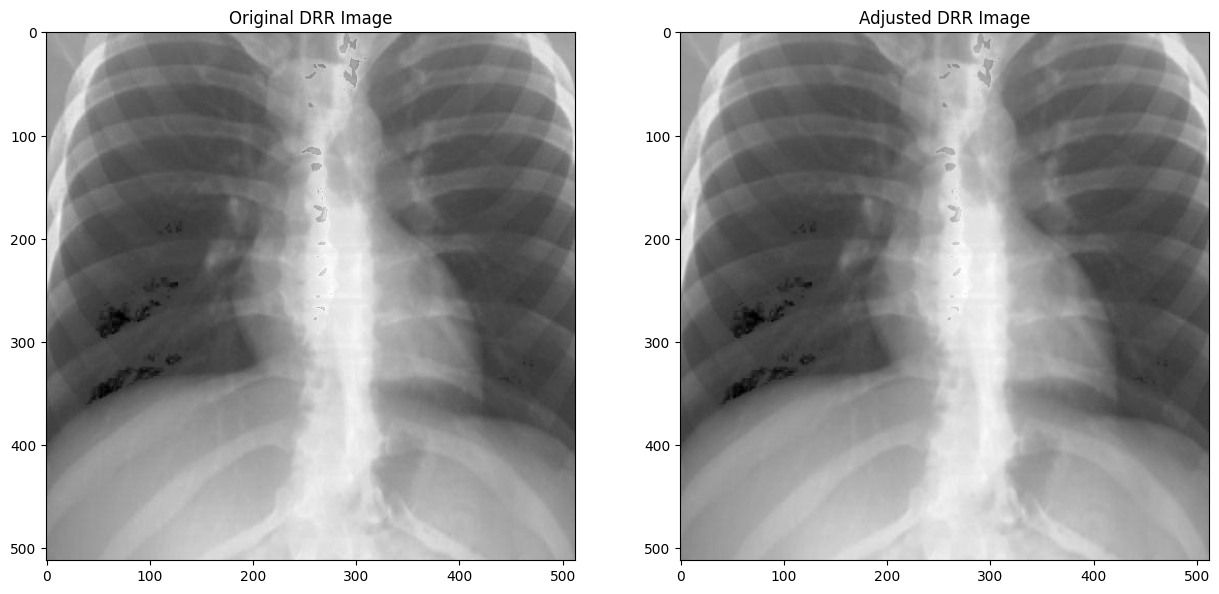

In [114]:
# Load the DRR image
image_path = r"d:\imgstd\avg_drr_piecewise_map\t_87_a_1.jpg"
image = np.array(Image.open(image_path).convert('L'))  # Convert to grayscale

# Apply the piecewise linear mapping
processed_image = apply_noise_and_blur(
    image_path,
    lower_bound=80,
    upper_bound=100,
    lower_noise_param=0.1,
    upper_noise_param= 0.3,
    lower_blur_param=0.2,
    upper_blur_param=0.5
)


# Plot the original and adjusted images
plt.figure(figsize=(15,15))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title("Original DRR Image")
plt.subplot(1, 2, 2)
plt.imshow(processed_image, cmap='gray')
plt.title("Adjusted DRR Image")
plt.show()

In [115]:
# Define the input and output directories
input_folder = r"D:\imgstd\avg_drr_04_piecewise_map"
output_folder = r"D:\imgstd\avg_drr_04_piecewise_map_blur"

# Create the output directory if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Iterate through all images in the input folder
for filename in os.listdir(input_folder):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        # Load the image
        image_path = os.path.join(input_folder, filename)
        image = np.array(Image.open(image_path).convert('L'))  # Convert to grayscale

        # Apply the piecewise linear mapping
        processed_image = apply_noise_and_blur(
                image_path,
                lower_bound=80,
                upper_bound=100,
                lower_noise_param=0.3,
                upper_noise_param= 0.5,
                lower_blur_param=0.6,
                upper_blur_param=1
            )

        # Save the adjusted image
        output_path = os.path.join(output_folder, filename)
        Image.fromarray(processed_image).save(output_path)

        print(f"Processed and saved: {output_path}")

Processed and saved: D:\imgstd\avg_drr_04_piecewise_map_blur\t_10168_a_1.jpg
Processed and saved: D:\imgstd\avg_drr_04_piecewise_map_blur\t_10292_a_1.jpg
Processed and saved: D:\imgstd\avg_drr_04_piecewise_map_blur\t_10325_a_1.jpg
Processed and saved: D:\imgstd\avg_drr_04_piecewise_map_blur\t_10894_a_1.jpg
Processed and saved: D:\imgstd\avg_drr_04_piecewise_map_blur\t_11021_a_1.jpg
Processed and saved: D:\imgstd\avg_drr_04_piecewise_map_blur\t_11170_a_1.jpg
Processed and saved: D:\imgstd\avg_drr_04_piecewise_map_blur\t_11322_a_1.jpg
Processed and saved: D:\imgstd\avg_drr_04_piecewise_map_blur\t_11626_a_1.jpg
Processed and saved: D:\imgstd\avg_drr_04_piecewise_map_blur\t_11810_a_1.jpg
Processed and saved: D:\imgstd\avg_drr_04_piecewise_map_blur\t_11917_a_1.jpg
Processed and saved: D:\imgstd\avg_drr_04_piecewise_map_blur\t_12122_a_1.jpg
Processed and saved: D:\imgstd\avg_drr_04_piecewise_map_blur\t_12209_b_1.jpg
Processed and saved: D:\imgstd\avg_drr_04_piecewise_map_blur\t_12389_a_1.jpg